<a href="https://colab.research.google.com/github/spi727/IIIT-Megathon/blob/main/IIITHackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Modules

In [2]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from transformers import pipeline
from multiprocessing import Pool, cpu_count
from datetime import datetime
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
import re
from sklearn.naive_bayes import BernoulliNB


import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Data Loading

In [ ]:
df=pd.read_excel('/content/drive/MyDrive/IIIT_Hackathon/mental_health_dataset.xlsx')
df.head(10)

,User Input,Polarity,Extracted Concern,Category,Intensity
0,I am constantly worried these days.,Negative,constantly worried,Health Anxiety,4
1,"I’m trying, but I’m still constantly worried.",Negative,constantly worried,Eating Disorder,3
2,I am worried about health these days.,Positive,worried about health,Anxiety,9
3,Every day I’m happy and excited.,Positive,happy and excited,Health Anxiety,1
4,I feel happy and excited lately.,Positive,happy and excited,Depression,1
5,"Sometimes, I think I'm feeling very low.",Negative,feeling very low,Insomnia,2
6,My mind feels like it’s can't sleep well.,Negative,can't sleep well,Health Anxiety,6
7,"It’s a struggle, I’m constantly worried.",Negative,constantly worried,Stress,10
8,"Lately, I’ve been feeling very anxious.",Neutral,feeling very anxious,Health Anxiety,1
9,"Sometimes, I think I'm feeling hopeful.",Negative,feeling hopeful,Health Anxiety,3


Data Preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   User Input         100000 non-null  object
 1   Polarity           100000 non-null  object
 2   Extracted Concern  100000 non-null  object
 3   Category           100000 non-null  object
 4   Intensity          100000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [ ]:
print(df.isnull().sum())

User Input           0
Polarity             0
Extracted Concern    0
Category             0
Intensity            0
dtype: int64


In [ ]:
sentiment_counts=df['Category'].value_counts()
print(sentiment_counts)

Category
Career Confusion    12599
Depression          12526
Eating Disorder     12517
Health Anxiety      12496
Stress              12495
Positive Outlook    12466
Insomnia            12462
Anxiety             12439
Name: count, dtype: int64


In [ ]:
polarity_counts=df['Polarity'].value_counts()
print(polarity_counts)

Polarity
Neutral     33651
Negative    33211
Positive    33138
Name: count, dtype: int64


In [ ]:
df.shape


(100000, 5)

count    100000.000000
mean         43.596800
std           7.910178
min          29.000000
25%          37.000000
50%          44.000000
75%          49.000000
max          68.000000
Name: statement_length, dtype: float64


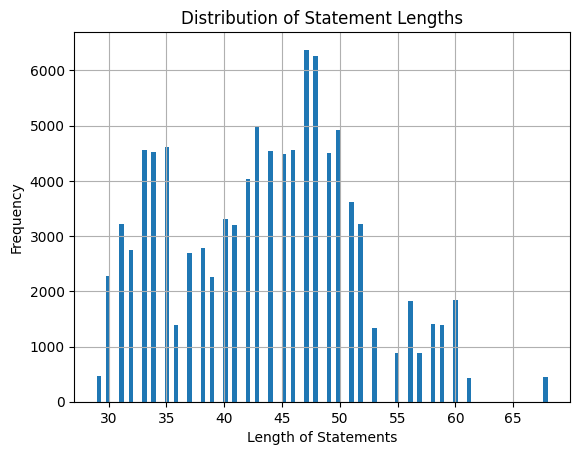

In [ ]:
df['statement_length'] = df['User Input'].apply(len)

# Display basic statistics of statement lengths
print(df['statement_length'].describe())

# Plot the distribution of statement lengths
df['statement_length'].hist(bins=100)
plt.title('Distribution of Statement Lengths')
plt.xlabel('Length of Statements')
plt.ylabel('Frequency')
plt.show()

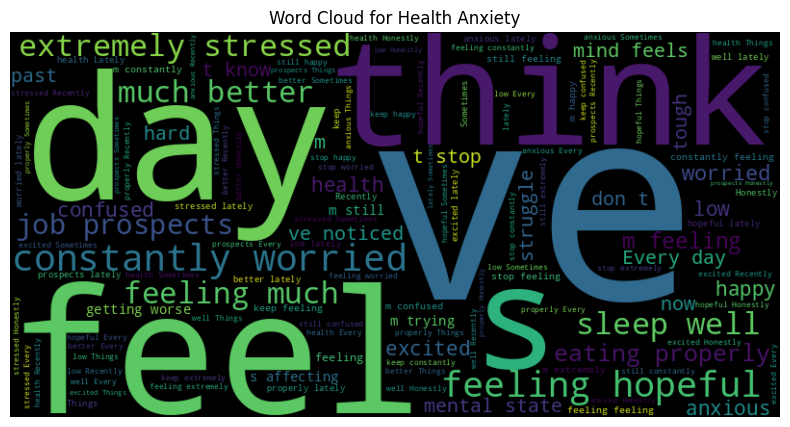

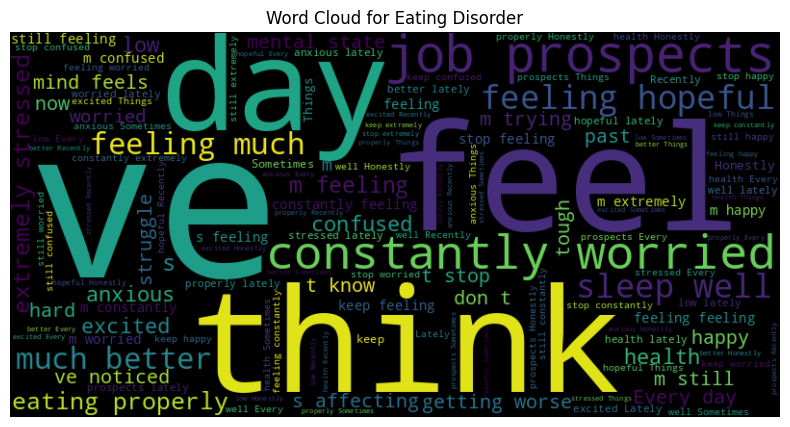

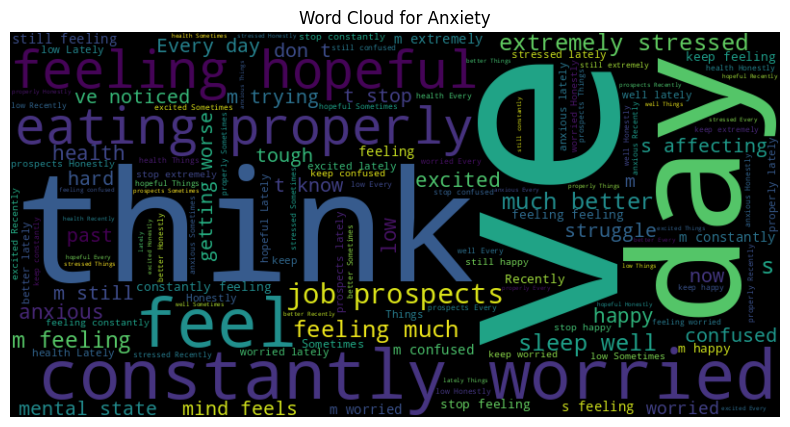

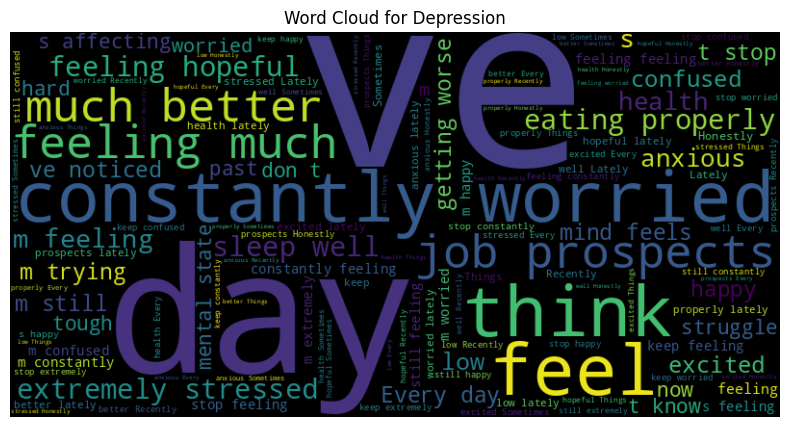

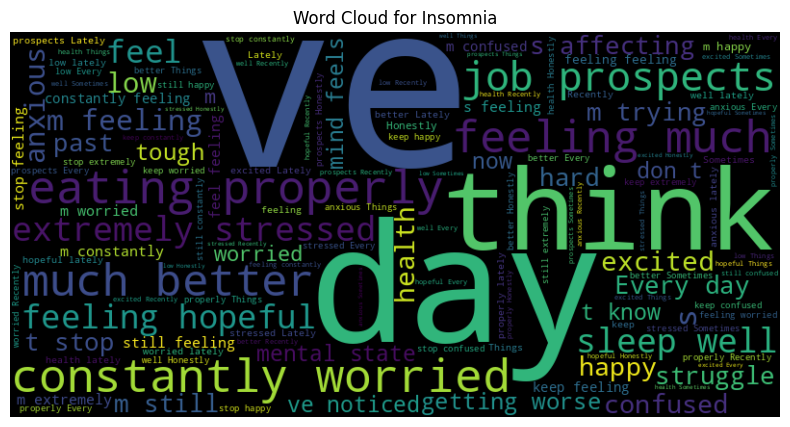

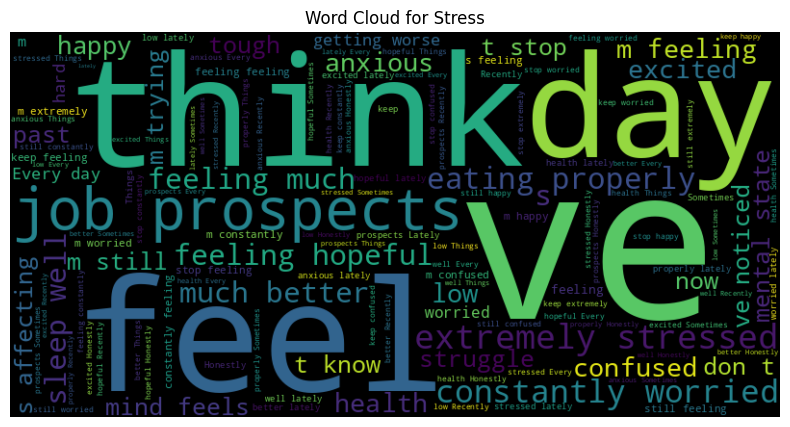

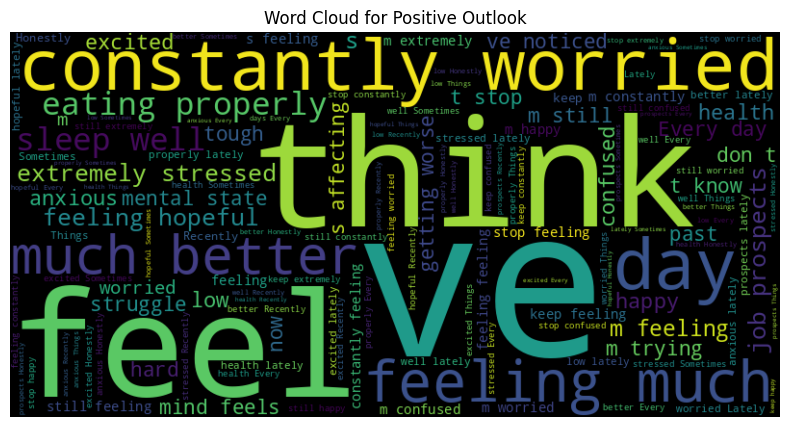

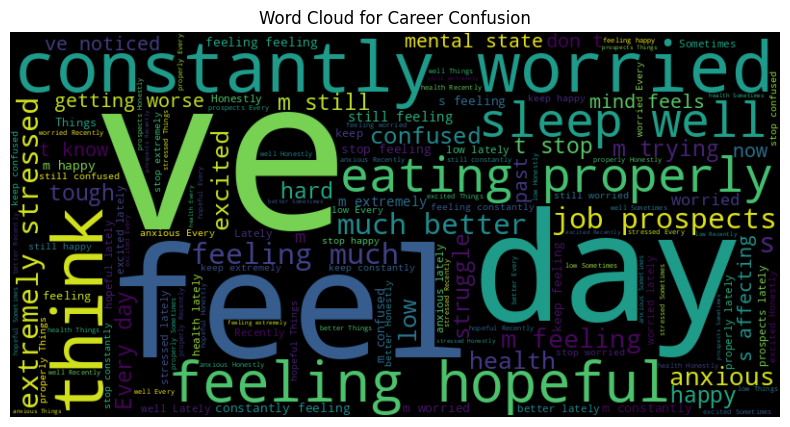

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a function to generate and display a word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds for each status
statuses = df['Category'].unique()

for status in statuses:
    status_text = ' '.join(df[df['Category'] == status]['User Input'])
    generate_word_cloud(status_text, title=f'Word Cloud for {status}')

In [19]:
%%writefile app.py

import streamlit as st
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import pandas as pd
from datetime import datetime

# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Load the set of English stop words
stop_words = set(stopwords.words('english'))

# Define preprocessing function
def preprocess_text(text):
    text = text.lower()
    words = word_tokenize(text)
    processed_text = [word for word in words if word not in stop_words and word not in string.punctuation]
    return ' '.join(processed_text)

# Load pre-trained models
model = SentenceTransformer('all-MiniLM-L6-v2')
sentiment_model = pipeline("sentiment-analysis")

# Define concern categories and keywords
concerns_keywords = {
    "Health Anxiety": ["health", "anxiety", "worried", "concerned"],
    "Eating Disorder": ["food", "eating", "diet", "binge", "restrict"],
    "Anxiety": ["anxious", "overwhelmed", "nervous", "panic"],
    "Depression": ["sad", "depressed", "down", "hopeless", "empty"],
    "Insomnia": ["sleep", "insomnia", "restless", "tired"],
    "Stress": ["stress", "overwork", "pressure", "burnout"],
    "Positive Outlook": ["happy", "grateful", "appreciate", "optimistic"],
    "Career Confusion": ["confused", "career", "lost", "direction", "future"]
}

# Define functions for analysis
def categorize_concern(text):
    for category, keywords in concerns_keywords.items():
        for keyword in keywords:
            if re.search(rf'\b{keyword}\b', text.lower()):
                return category, keyword
    return "General", None

def get_context(text, keyword):
    words = re.findall(r'\b\w+\b', text)
    for i, word in enumerate(words):
        if word.lower() == keyword:
            prev_word = words[i - 1] if i > 0 else ''
            next_word = words[i + 1] if i < len(words) - 1 else ''
            return prev_word, next_word
    return '', ''

def analyze_sentiment(text):
    sentiment_result = sentiment_model(text)[0]
    label = sentiment_result['label']
    score = sentiment_result['score']
    polarity = "Positive" if label == 'POSITIVE' else "Negative"
    return polarity, score

def calculate_intensity(score, label):
    return round((score * 9) + 1) if label == 'POSITIVE' else round(((1 - score) * 9) + 1)

def analyze_text(text):
    polarity, score = analyze_sentiment(text)
    concern_category, keyword = categorize_concern(text)
    if keyword:
        prev_word, next_word = get_context(text, keyword)
        context = f"{prev_word} {keyword} {next_word}"
    else:
        context = "No relevant context found."
    intensity = calculate_intensity(score, polarity)
    return polarity, concern_category, intensity, context

def run_pipeline(sentences):
    results = []
    for sentence in sentences:
        polarity, category, intensity, context = analyze_text(sentence)
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        results.append({
            "Timestamp": timestamp,
            "Sentence": sentence,
            "Polarity": polarity,
            "Concern Category": category,
            "Intensity": intensity,
            "Context": context
        })
    return results

# Streamlit UI
st.title("Mental Health Analysis Pipeline with Time Series")
st.write("Analyze mental health concerns, sentiment, intensity, and view intensity over time.")

# Input area for sentences
user_input = st.text_area("Enter sentences (one per line):", height=200)

# If 'Analyze' button is clicked
if st.button("Analyze"):
    if not user_input.strip():
        st.error("Please enter at least one sentence.")
    else:
        # Preprocess and run analysis
        sentences = [line.strip() for line in user_input.split('\n') if line.strip()]
        sentences = [preprocess_text(sentence) for sentence in sentences]
        results = run_pipeline(sentences)

        # Display each analysis result
        st.subheader("Analysis Results")
        for result in results:
            st.write(f"**Timestamp:** {result['Timestamp']}")
            st.write(f"**Sentence:** {result['Sentence']}")
            st.write(f"**Polarity:** {result['Polarity']}")
            st.write(f"**Concern Category:** {result['Concern Category']}")
            st.write(f"**Intensity:** {result['Intensity']}")
            st.write(f"**Context:** {result['Context']}")

        # Time series analysis for intensity
        if st.button("Show Intensity Time Series Analysis"):
            # Create a DataFrame from the results
            df = pd.DataFrame(results)
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # Convert timestamps to DateTime format
            df.set_index('Timestamp', inplace=True)  # Set timestamp as the index

            # Plot the time series chart for intensity
            st.subheader("Intensity Over Time")
            st.line_chart(df['Intensity'])  # Display line chart for intensity

            # Display cumulative and average intensity
            cumulative_sum = df['Intensity'].sum()
            avg_intensity = df['Intensity'].mean()
            st.write(f"**Cumulative Sum of Intensity:** {cumulative_sum:.2f}")
            st.write(f"**Average Intensity:** {avg_intensity:.2f}")


Overwriting app.py


In [2]:
!npm install localtunnel


up to date, audited 23 packages in 611ms

3 packages are looking for funding
  run `npm fund` for details

2 moderate severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.


In [20]:
!streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.170.79.235
your url is: https://ninety-apes-relax.loca.lt
